In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
%matplotlib inline
%reload_ext autoreload
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json
from orbsim.r3b_2d import UNIT_TIME
from orbsim.r3b_2d.analyticals import *
from orbsim.r3b_2d.simulators import launch_sim
from orbsim.plotting import orbitplot2d, orbitplot_non_inertial
import time
from random import shuffle
from numba import jit
import math
from math import pi
%aimport orbsim.r3b_2d.simulators
%aimport orbsim.plotting
%autoreload
 

pi8=pi/8
pi4=pi/4
pi2=pi/2

In [2]:
psis=[]
paths=[]
title="long_leto_lyapunov"
N=5
for i in range(N):
    psi = [3.794182930145708, 0.023901745288554, 3.090702702702703+i/1e3]
    path = launch_sim(psi,max_iter=1e7, duration=100/UNIT_TIME)
    psis.append(psi)
    paths.append(path)


In [212]:
for i in range(len(paths)):
    orbitplot2d(paths[i],psis[i],filepath="./lyapunov_figs/trajectories",title="{title}_{i}")
    orbitplot_non_inertial(paths[i],psis[i],filepath="./lyapunov_figs/trajectories",title="{title}_{i}")

SyntaxError: invalid syntax (<ipython-input-212-07a7d03168a6>, line 2)

In [4]:
lyaps=[]
for a in range(N):
    for b in range(N):
        print(f"comparing {a} and {b}")
        if a>=b:
            continue
        lyap=[]
        _a=np.array(paths[a][1]).T
        _b=np.array(paths[b][1]).T
        xas=_a[0]
        yas=_a[1]
        xbs=_b[0]
        ybs=_b[1]
        hs=(_a[4],_b[4])
        print(f"length of the trajectory coordinate arrays: {a}: {len(xas)}, {b}: {len(xbs)}")
        
        ts=[None,None]
        for l in range(len(hs)):
            idxs=[]
            tally=0
            for i in range(len(hs[l])): # each time step h, check whether the little tally has reached our threshold.
                h=hs[l][i]              # if it has, take that index as a time step
                tally+=h
                if tally>=1.5e-5:
                    idxs.append(i)
                    tally=0
            ts[l] = idxs
            
        _,min_ts = min([(x[-1], x) for x in ts])
        print(f"time steps standardized: comparing at {len(min_ts)} points on the trajectory. Last point will be at {max(min_ts)}")
        for i in range(len(min_ts)):
            idx=min_ts[i]
            lyap.append(sqrt((xas[idx]-xbs[idx])**2+(yas[idx]-ybs[idx])**2))
        lyaps.append(lyap)
print(len(lyaps))

comparing 0 and 0
comparing 0 and 1
length of the trajectory coordinate arrays: 0: 3263765, 1: 3004458
time steps standardized: comparing at 904931 points on the trajectory. Last point will be at 3004457
comparing 0 and 2
length of the trajectory coordinate arrays: 0: 3263765, 2: 3002247
time steps standardized: comparing at 893458 points on the trajectory. Last point will be at 3002246
comparing 0 and 3
length of the trajectory coordinate arrays: 0: 3263765, 3: 3043766
time steps standardized: comparing at 888600 points on the trajectory. Last point will be at 3043765
comparing 0 and 4
length of the trajectory coordinate arrays: 0: 3263765, 4: 3105159
time steps standardized: comparing at 884578 points on the trajectory. Last point will be at 3105158
comparing 1 and 0
comparing 1 and 1
comparing 1 and 2
length of the trajectory coordinate arrays: 1: 3004458, 2: 3002247
time steps standardized: comparing at 893458 points on the trajectory. Last point will be at 3002246
comparing 1 and 

In [5]:
loglyaps=[]
for i in range(len(lyaps)):
    lyap=lyaps[i][1:]
    loglyap=[np.log(x) for x in lyap]
    loglyaps.append(loglyap)

In [6]:
def find_segments(lyap):
    segments=[]
    prev_l = -1e8
    rising = True
    segment=[0]
    for i,l in enumerate(lyap):
        if rising:
            if l<prev_l:
                rising = False
                segment.append(i)
        else:
            if l>prev_l:
                rising = True
                segments.append(segment)
                segment=[i]
        prev_l = l
    if len(segment) == 1:
        segment.append(len(lyap))
    segments.append(segment)
    return segments

In [16]:
from scipy import stats
def compute_slope(lyap, filepath=".", title="derp"):
    segments=find_segments(lyap)
    plt.plot(range(len(lyap)),lyap,color='grey',alpha=0.5)
    slopes=[]
    for lb, ub in [[int(x),int(y)] for [x,y] in segments]:
        if ub-lb < 100:
            continue
        if ub>len(lyap):
            break
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(lb,ub),lyap[lb:ub])
        slopes.append(slope)
        #print(slope, intercept)
        line=slope*range(lb,ub)+intercept
        plt.plot([lb,ub],[line[0],line[-1]],color='darkred')
        plt.plot(range(lb,ub),lyap[lb:ub],color='teal')
    mean_slope = np.mean(slopes)
    plt.suptitle(f"mean slope = {mean_slope}")
    plt.savefig(f"{filepath}/{title}")
    plt.clf()
    return mean_slope

In [ ]:
slopes=[]
for i, loglyap in enumerate(loglyaps):
    slopes.append(compute_slope(loglyap,filepath="lyapunov_figs/slopes",title=f"{title}_{i}"))
print(f"mean slope = {np.mean(slopes)}")
    

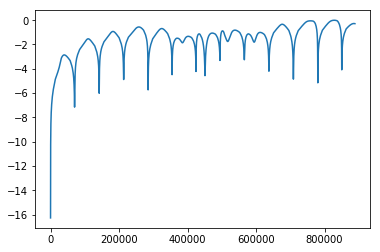

In [150]:
lyap=lyaps[2][1:]
loglyap=[np.log(x) for x in lyap]
plt.plot(range(len(loglyap)),loglyap)

In [100]:
slope, intercept, r_value, p_value, std_err = stats.linregress(range(lb,ub),loglyap[lb:ub])
print(slope, intercept)

3.040160021068095e-06 -4.150509459758794


In [75]:
line=slope*range(lb,ub)+intercept